In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 11 2021

@author: Zsuzsanna Koczor-Benda, UCL
"""

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from plotting_functions import get_intensities,broadened_spec_single,get_intens_range,get_target,build_molecules,plot_spectra,write_html

In [3]:
# RDKit for molecule depiction
# https://www.rdkit.org/docs/Install.html
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# CairoSVG for converting svg to png image
#from cairosvg import svg2png

# Pandas for displaying data table
#from pandas import DataFrame as df

# Load data for all molecules

In [4]:
# Change variables here

xmin=30     # minimum wavenumber to load (in cm-1), default=30
xmax=1000   # maximum wavenumber to load (in cm-1), default=1000
res=0.5     # resolution of the widened spectra (in cm-1), default=0.5
gammaIR=5   # IR peak FWHM (in cm-1), default=5
gammaR=5    # Raman peak FWHM (in cm-1), default=5
sclf=0.98   # wavenumber scaling factor, default=0.98 

In [5]:
# Quantities to load:

# wn, R_spec, IR_spec:               wavenumbers, Raman and IR broadened spectra
# freqs:                             normal mode frequencies 
# prod_ints, R_ints, IR_ints:        conversion, Raman, and IR intensties for each normal mode
# smiles, fname:                     smiles codes and database codes of molecules
# P, A, R:                           THz conversion, IR absorption, and Raman target properties for xmin-xmax range

# get intensities and target properties for all molecules
freqs,prod_ints,R_ints,IR_ints,smiles,fname,P,A,R,R_fre,IR_fre,P_fre=get_intensities(xmin,xmax,sclf)

# get broadened spectrum for all molecules -- slow
#wn,R_spec,IR_spec,conv_spec,freqs,prod_ints,R_ints,IR_ints,smiles,fname,P,A,R=create_average_spec(xmin,xmax,res,gammaIR,gammaR,sclf)

2847 molecules read, maximum number of normal modes: 186
Target properties calculated


# Find molecules based on P, A, or R target in a custom frequency range

In [6]:
# Change variables here
# Only these molecules will be plotted

nummols=3        # number of molecules to plot
target_type="P"   # which target to use for sorting molecules: "P","A" or "R"
best=True         # get best molecules (True) or worst molecules (False)
tmin=700     # frequency range to search, lower bound (cm-1)
tmax=1000         # upper bound (cm-1)

# Distribution of chosen target property values in the database

In [18]:
# Distribution of P,A, or R for range 30-1000 cm-1 is centered at 0 with std=1 for random set of molecules
# Current dataset contains 1.3k random molecules + 1.5k molecules selected based on ML predictions
def plot_histogram(target_type,trange):
    tmin=trange[0]
    tmax=trange[1]
    if target_type=="P":
        intens=prod_ints
    elif target_type=="R":
        intens=R_ints
    else:
        intens=IR_ints
    intens_range=get_intens_range(freqs,intens,tmin,tmax)      # get intensities in freq range
    target=get_target(intens_range,target_type)                # get chosen target for freq range
    if best:
        bestmols=list(reversed(np.argsort(target)[-nummols:])) # best molecules
    else:
        bestmols=np.argsort(target)[:nummols]                  # worst molecules
    bestsmiles=[smiles[i] for i in bestmols]                   # corresponding smiles codes
    mols,errs =  build_molecules(bestsmiles)                   # build RDKit molecules
    print("Total number of molecules: {}, chosen: {}, number of errors: {} at mols {}".format(len(smiles),
                                                                                              len(mols),len(errs),errs))

    if np.isinf(target).any():    # if there are molecules with 0 intensity in range, target will be -infinity
        print("skipped -inf values")
        print("Number of molecules with no modes in range: ",len(target[target < -1E2]))
    plt.hist(target[target > -1E2],20,width=0.25)  # skip molecules with too small target value 
    plt.xlabel("{} for range {}-{} cm-1".format(target_type,tmin,tmax))
    plt.ylabel("counts")
    plt.show()


In [21]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import HBox, Layout,VBox

interactive_plot = interactive(plot_histogram, {'manual': True}, 
         target_type=widgets.RadioButtons(options=[('P'), ('A'),('R')],
                                          description='Target:',
                                          style={'description_width': 'initial'},
                                          disabled=False),
         trange=widgets.FloatRangeSlider(
                    min=0,
                    max=3500,
                    step=1,
                    continuous_update=False,
                    orientation='horizontal',
                )
         );

output = interactive_plot.children[-1]
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap')) #'column'))
output.layout.height = '700px'
#interactive_plot
display(VBox([controls,output]))

# Visualize and save chosen molecules

In [8]:
# Change variables here
# saving slows down code

savemol=0     # save molecule depiction as svg and png, run once for HTML summary
savespec=0    # save spectra as png, run once for HTML summary
savecsv=0    # save broadened spectrum data as CSV
nummodes=3       # number of best normal modes per molecule to print out
Sigma=0


###################################################################
Molecule 000-713-699
###################################################################


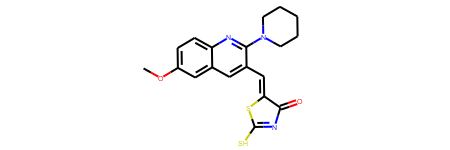

Properties for range 30-1000 cm-1 
P=5.891 A=2.036 R=2.400
P for range 700-1000 cm-1 = 5.874
0 2000


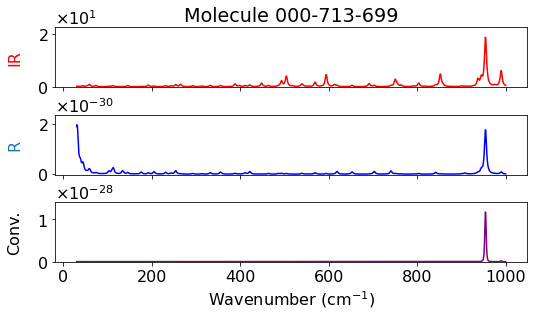


Best normal modes in range 700-1000 cm-1, type P
--------------------------------------------------
Mode 60 at 954.1 cm-1 / 28.60 THz
Conversion Intensity 	7.23e-27 km cm^2/(sr mol)
Raman Stokes Intensity 	1.35e-29 cm^2/sr
IR Intensity 		1.41e+02 km/mol
--------------------------------------------------
Mode 64 at 989.5 cm-1 / 29.67 THz
Conversion Intensity 	1.08e-28 km cm^2/(sr mol)
Raman Stokes Intensity 	6.03e-31 cm^2/sr
IR Intensity 		4.60e+01 km/mol
--------------------------------------------------
Mode 59 at 944.6 cm-1 / 28.32 THz
Conversion Intensity 	3.28e-29 km cm^2/(sr mol)
Raman Stokes Intensity 	1.07e-30 cm^2/sr
IR Intensity 		2.23e+01 km/mol
--------------------------------------------------

###################################################################
Molecule 000-823-384
###################################################################


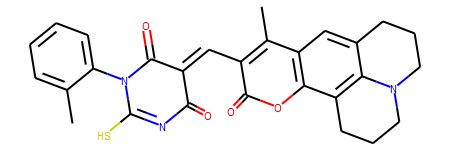

Properties for range 30-1000 cm-1 
P=6.269 A=3.091 R=4.334
P for range 700-1000 cm-1 = 5.537
0 2000


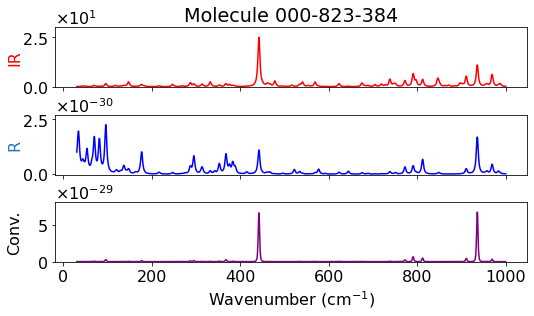


Best normal modes in range 700-1000 cm-1, type P
--------------------------------------------------
Mode 79 at 935.4 cm-1 / 28.04 THz
Conversion Intensity 	4.12e-27 km cm^2/(sr mol)
Raman Stokes Intensity 	1.32e-29 cm^2/sr
IR Intensity 		8.51e+01 km/mol
--------------------------------------------------
Mode 67 at 790.5 cm-1 / 23.70 THz
Conversion Intensity 	4.01e-28 km cm^2/(sr mol)
Raman Stokes Intensity 	2.84e-30 cm^2/sr
IR Intensity 		4.83e+01 km/mol
--------------------------------------------------
Mode 69 at 812.1 cm-1 / 24.35 THz
Conversion Intensity 	2.95e-28 km cm^2/(sr mol)
Raman Stokes Intensity 	5.21e-30 cm^2/sr
IR Intensity 		2.76e+01 km/mol
--------------------------------------------------

###################################################################
Molecule 46538653
###################################################################


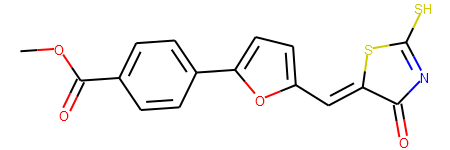

Properties for range 30-1000 cm-1 
P=5.359 A=2.217 R=1.808
P for range 700-1000 cm-1 = 5.321
0 2000


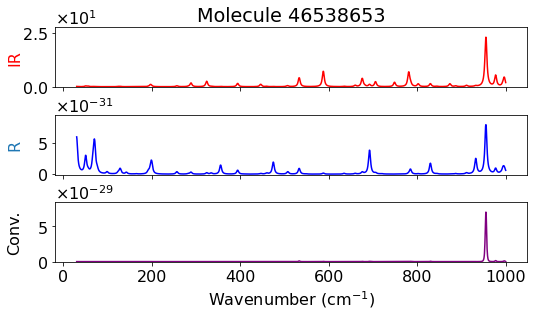


Best normal modes in range 700-1000 cm-1, type P
--------------------------------------------------
Mode 50 at 955.2 cm-1 / 28.63 THz
Conversion Intensity 	4.34e-27 km cm^2/(sr mol)
Raman Stokes Intensity 	6.11e-30 cm^2/sr
IR Intensity 		1.80e+02 km/mol
--------------------------------------------------
Mode 51 at 977.1 cm-1 / 29.29 THz
Conversion Intensity 	8.70e-29 km cm^2/(sr mol)
Raman Stokes Intensity 	6.09e-31 cm^2/sr
IR Intensity 		3.96e+01 km/mol
--------------------------------------------------
Mode 54 at 996.7 cm-1 / 29.88 THz
Conversion Intensity 	6.34e-29 km cm^2/(sr mol)
Raman Stokes Intensity 	5.71e-31 cm^2/sr
IR Intensity 		3.03e+01 km/mol
--------------------------------------------------


In [9]:
conv_data=np.zeros((nummols*nummodes,7))
cm_thz=0.0299792458 # conversion factor from cm-1 to THz

for nm,mm in enumerate(bestmols):
    print("\n###################################################################")
    if Sigma:
        mcode="Sigma-"+fname[mm]
    else:
        mcode=fname[mm].split("_",1)[0]
    
    print("Molecule {}".format(mcode.split("-",1)[1]))
    print("###################################################################")
    display(mols[nm])
    print("Properties for range {}-{} cm-1 \nP={:.3f} A={:.3f} R={:.3f}".format(xmin,xmax,P[mm],A[mm],R[mm]))
    print("{} for range {}-{} cm-1 = {:.3f}".format(target_type,tmin,tmax,target[mm]))
    
    
    wn,R_spec,IR_spec,conv_spec=broadened_spec_single(freqs[mm],  
                                                        IR_fre[mm], R_fre[mm], P_fre[mm],
                                                        xmin,xmax,res,gammaIR,gammaR,sclf)
    
    plot_spectra(wn,R_spec,IR_spec,conv_spec,xmin,xmax,res,mcode,savespec)
    
    if savecsv:
        ofilenm="./figures/{}_Raman.csv".format(mcode)
        with open(ofilenm,'w') as fout:
            for p in range(len(wn)):
                fout.write("{},{}\n".format(wn[p],R_spec[mm,p]))
        ofilenm="./figures/{}_IR.csv".format(mcode)
        with open(ofilenm,'w') as fout:
            for p in range(len(wn)):
                fout.write("{},{}\n".format(wn[p],IR_spec[mm,p]))
        print("Saved spectra in csv")

    if savemol:
        try:
            svg_filename="./figures/{}_mol.svg".format(mcode)
            Chem.Draw.MolToFile(mols[nm],"./figures/{}_mol.svg".format(mcode),ImgSize=(100,100))
            svg_path=svg_filename
            png_name=svg_filename[:-3]+"png"
            svg2png(url=svg_path,write_to=png_name)
            print("Saved molecule depiction")
        except:
            print("Error with drawing molecule")

    bestmodes=np.argsort(intens_range[mm,:],axis=0)[-nummodes:]
    print("\nBest normal modes in range {}-{} cm-1, type {}".format(tmin,tmax,target_type))
    print("--------------------------------------------------")
    for mi,mode in enumerate(reversed(bestmodes)):         
                        if intens_range[mm,mode]==0:
                            conv_data[nm*nummodes+mi,:]=0
                            print("Mode with zero target intensity")
                            print("--------------------------------------------------")
                            continue
                        freqm=freqs[mm,mode]
                        thz=cm_thz*freqm
                        print("Mode {} at {:.1f} cm-1 / {:.2f} THz".format(mode,freqm,thz))
                        print("Conversion Intensity \t{:.2e} km cm^2/(sr mol)".format(prod_ints[mm,mode]))
                        print("Raman Stokes Intensity \t{:.2e} cm^2/sr".format(R_ints[mm,mode]))
                        print("IR Intensity \t\t{:.2e} km/mol".format(IR_ints[mm,mode]))
                        print("--------------------------------------------------")
                        conv_data[nm*nummodes+mi,0]=mm
                        conv_data[nm*nummodes+mi,1]=mode
                        conv_data[nm*nummodes+mi,2]=freqm
                        conv_data[nm*nummodes+mi,3]=thz
                        conv_data[nm*nummodes+mi,4]=prod_ints[mm,mode]
                        conv_data[nm*nummodes+mi,5]=R_ints[mm,mode]
                        conv_data[nm*nummodes+mi,6]=IR_ints[mm,mode]

# Table summary of best normal modes

In [41]:
# dat=df(conv_data, columns=['Molecule no.','Mode no.','Freq (cm$^{-1}$)','Freq (THz)','Conv. Int. (km cm$^2$/(sr mol))',
#                            'Raman Int. (cm$^2$/sr)','IR Int. (km/mol)'])
# display(dat)

# Create a HTML summary of chosen molecules

In [42]:
# For displaying properly it needs image files in ./figures/
# Run plotting with savemol=1 and savespec=1 to save these image files

# write_html(bestmols,smiles,P,A,R,
#             fname,xmin,xmax,target,tmin,tmax,target_type,Sigma)

3
Molecule  COc1ccc2c(c1)cc(c(n2)N1CCCCC1)/C=C/1\SC(=NC1=O)S


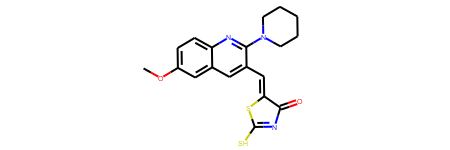

Most similar SAM molecule:  Nc1ccc2nc(S)sc2c1  similarity:  0.43243243243243246


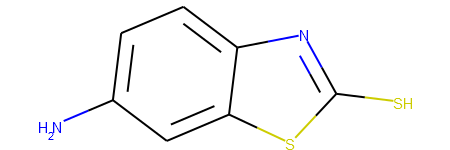

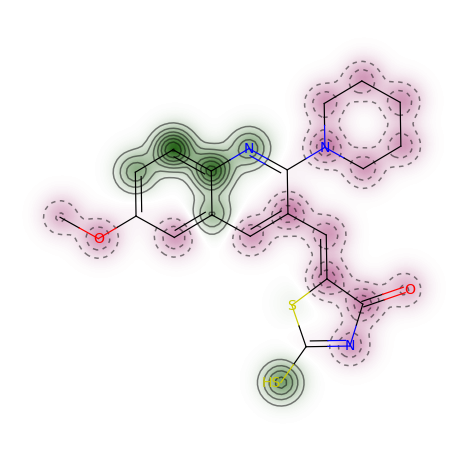

Molecule  O=C1N=C(S)N(C(=O)C1=Cc1c(=O)oc2c(c1C)cc1c3c2CCCN3CCC1)c1ccccc1C


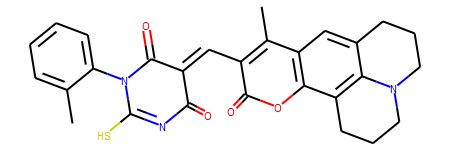

Most similar SAM molecule:  SC1=NC2=CC=CC=C2O1  similarity:  0.34782608695652173


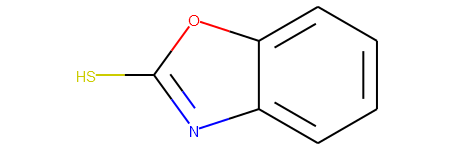

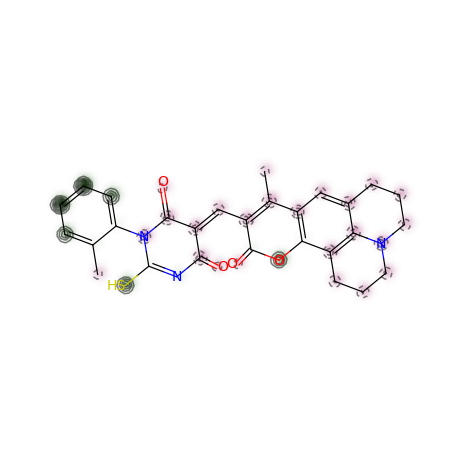

Molecule  COC(=O)c1ccc(cc1)c1ccc(o1)/C=C/1\SC(=NC1=O)S


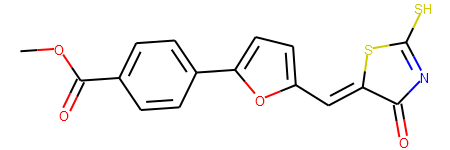

Most similar SAM molecule:  SC1=CC=C(C=C1)C1=CC=NC=C1  similarity:  0.5277777777777778


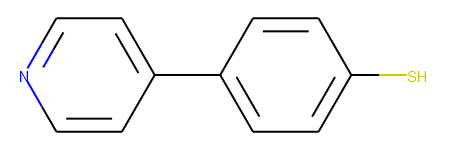

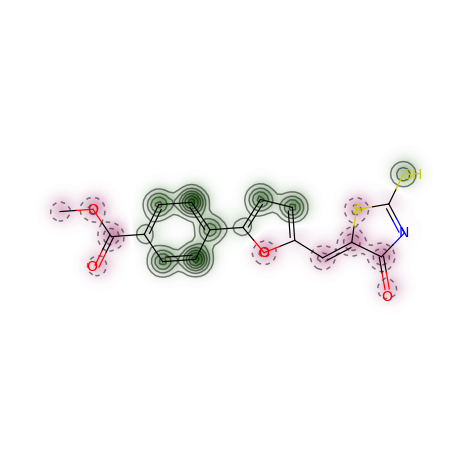

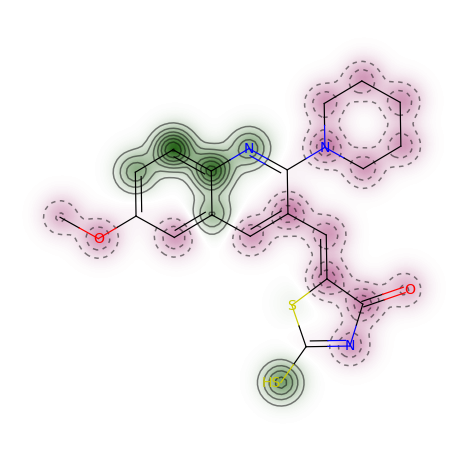

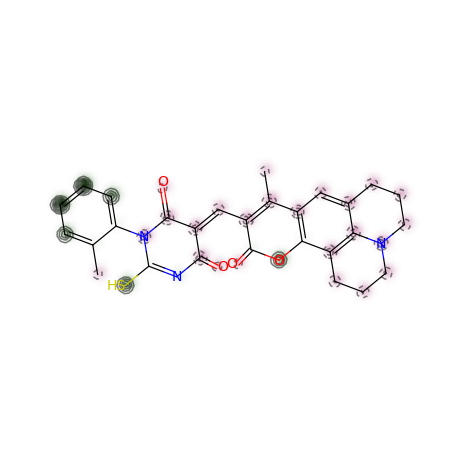

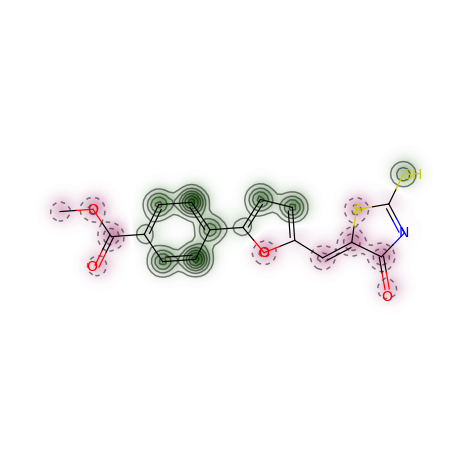

In [45]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem import AllChem

def read_smiles_data(fname="freq_data.txt"):
    SAMsmiles=[]
    with open(fname) as inpfile:
        line = inpfile.readline()
        while line:
            SAMsmiles.append(line.split()[1])
            line = inpfile.readline()
    return SAMsmiles

SAMsmiles=read_smiles_data("smiles_SAM_materials.txt")
ms=[]
rad=1
for s in SAMsmiles:
    if Chem.MolFromSmiles(s)==None:
        ms.append(None)
        continue
    m=Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(s)))
    ms.append(m) 
fps=[]
for x in ms:
    if x==None:
        fps.append(None)
        continue
# Different types of fingerprints
#    fps.append(Chem.RDKFingerprint(x,useHs=False))
    fps.append(AllChem.GetMorganFingerprint(x, radius=rad, useCounts=1,useFeatures=0))
#    fps.append(Generate.Gen2DFingerprint(x,sigFactory))


testfps = [AllChem.GetMorganFingerprint(x, radius=rad, useCounts=1,useFeatures=0)  for x in mols]
#testfps = [Generate.Gen2DFingerprint(x,sigFactory) for x in mols]

sim=np.zeros((len(testfps),len(fps)))
for i,tf in enumerate(testfps):
    for j, fps2 in enumerate(fps):
        if fps2==None:
            sim[i,j]=0
            continue
# Different similarity measures
     #   sim[i,j]=DataStructs.FingerprintSimilarity(tf,fps2)#,metric=DataStructs.DiceSimilarity)
     #   sim[i,j]=DataStructs.TanimotoSimilarity(tf,fps2) #
        sim[i,j]=DataStructs.DiceSimilarity(tf,fps2)

maxsim=np.max(sim,axis=1)
bestm=np.argsort(maxsim)

from IPython.display import  display
for m in range(len(bestm)):
    print("Molecule ",bestsmiles[m])
    display(mols[m])
    mmol=np.argsort(sim[m,:])[-1] 
    print("Most similar SAM molecule: ",SAMsmiles[mmol], " similarity: ",DataStructs.DiceSimilarity(testfps[m],fps[mmol]))
    display(ms[mmol])
    fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint( 
                    ms[mmol], mols[m],lambda mo,
                    idx: SimilarityMaps.GetMorganFingerprint(mo, atomId=idx, radius=rad, 
                                                             useFeatures=0,fpType='count'), 
                    metric=DataStructs.DiceSimilarity)
         #           metric=DataStructs.TanimotoSimilarity)
  #  fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(testms[m], ms[np.argmax(sim[m,:])], lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    display(fig)
    


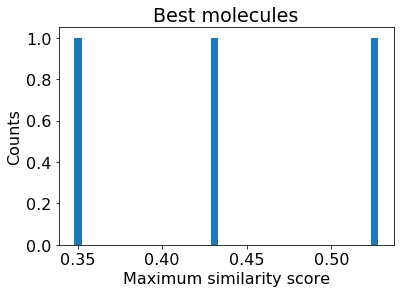

In [46]:
fig=plt.figure()    

plt.hist(maxsim,40)

plt.title("Best molecules")
plt.xlabel("Maximum similarity score")
plt.ylabel("Counts")
plt.show()